In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [73]:
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, Compose

transform = Compose([
    RandomRotation(10),        # Rotate images ±10 degrees
    RandomHorizontalFlip(0.5), # Flip 50% of images horizontally  
    ToTensor(),
])

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform
)

In [74]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [75]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [82]:
# Device configuration - Force CPU for MacBook
device = torch.device("mps")
print(f"Using device: {device}")

# Define model
'''class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            #nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            #nn.Dropout(0.3),    
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)'''

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 → 28x28, 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28 → 14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14 → 14x14, 64 channels
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 14x14 → 7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 7x7 → 7x7, 128 channels
            nn.ReLU(),
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Create the model
model = ConvNet().to(device)

Using device: mps


In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # Reduce every 3 epochs

In [84]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [85]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [87]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.063581  [   64/60000]
loss: 0.136205  [ 6464/60000]
loss: 0.026248  [12864/60000]
loss: 0.215468  [19264/60000]
loss: 0.119849  [25664/60000]
loss: 0.295122  [32064/60000]
loss: 0.128532  [38464/60000]
loss: 0.230299  [44864/60000]
loss: 0.155776  [51264/60000]
loss: 0.134788  [57664/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.328210 

Epoch 2
-------------------------------
loss: 0.107655  [   64/60000]
loss: 0.203695  [ 6464/60000]
loss: 0.064690  [12864/60000]
loss: 0.168232  [19264/60000]
loss: 0.323260  [25664/60000]
loss: 0.325291  [32064/60000]
loss: 0.115655  [38464/60000]
loss: 0.194037  [44864/60000]
loss: 0.131129  [51264/60000]
loss: 0.188712  [57664/60000]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.346982 

Epoch 3
-------------------------------
loss: 0.201988  [   64/60000]
loss: 0.084000  [ 6464/60000]
loss: 0.093258  [12864/60000]
loss: 0.158969  [19264/60000]
loss: 0.147987  [25664/60000]
loss: 0.286394  [32064/600

In [88]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [90]:
model = ConvNet().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [92]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.unsqueeze(0).to(device)  # Add batch dimension: [1, 28, 28] → [1, 1, 28, 28]
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [93]:
'''classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')'''

'classes = [\n    "T-shirt/top",\n    "Trouser",\n    "Pullover",\n    "Dress",\n    "Coat",\n    "Sandal",\n    "Shirt",\n    "Sneaker",\n    "Bag",\n    "Ankle boot",\n]\n\nmodel.eval()\nx, y = test_data[0][0], test_data[0][1]\nwith torch.no_grad():\n    x = x.to(device)\n    pred = model(x)\n    predicted, actual = classes[pred[0].argmax(0)], classes[y]\n    print(f\'Predicted: "{predicted}", Actual: "{actual}"\')'

In [95]:
for features, labels in train_dataloader:
    print("Features:", features.shape)
    print("Labels:", labels)
    break


Features: torch.Size([64, 1, 28, 28])
Labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


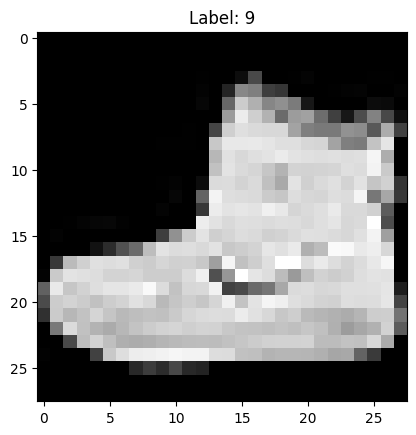

In [96]:
import matplotlib.pyplot as plt

for X, y in train_dataloader:
    plt.imshow(X[0].squeeze(), cmap="gray")
    plt.title(f"Label: {y[0]}")
    plt.show()
    break


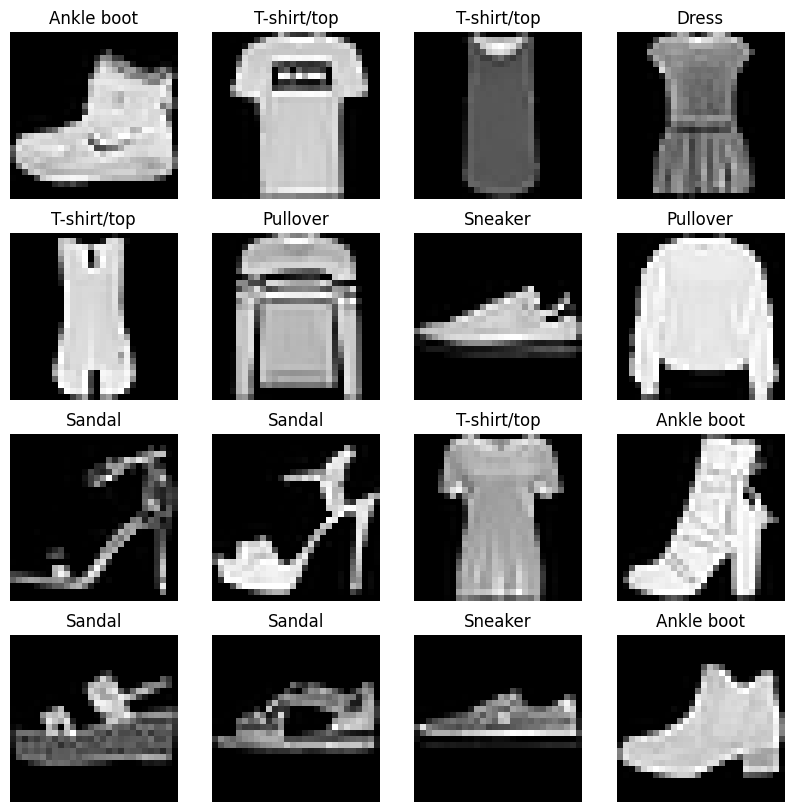

In [97]:
import matplotlib.pyplot as plt

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

X, y = next(iter(train_dataloader))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i].squeeze(), cmap="gray")
    plt.title(classes[y[i]])
    plt.axis("off")
plt.show()
